<a href="https://colab.research.google.com/github/amedboye/amed/blob/master/test_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# Ce texte est au format code
```
 3 actifs corrélés dont 2 simulés avec Heston et l'autre BS_Garch \\
 1 actif non corrélé aux 3 premiers



In [ ]:
import numpy as  np 
import matplotlib.pyplot as plt 
import pandas as  pd
from math import  *
import random as rd


In [ ]:

def MB(cov, N):
    mu = np.zeros(len(cov))
    W = np.random.multivariate_normal(mu, cov, size=N)
    return W

def BS(liste_prix, liste_u, liste_sigma, N, mb, T):
    pas = T/N 
    n_actifs = len(liste_u)
    liste = liste_prix.copy()
    liste_S = np.zeros((N, n_actifs))
    for k in range(N):
      for j in range(n_actifs):

        liste[j] = liste[j]*exp((liste_u[j]-0.5*liste_sigma[j]**2)*pas + liste_sigma[j]*mb[k,j]*np.sqrt(pas))
        liste_S[k,j]=liste[j]
    
    return liste_S

def Heston(liste_prix, liste_u, liste_sigma, mu_sigma, N, mb, T, rho=0.7, beta=1.0, alpha=0.1):
    pas = T/N
    n_actifs = len(liste_u)
    liste  = liste_prix.copy()
    liste_S = np.zeros((N, n_actifs))
    #Y processus OU
    #Z_cor mb corrélé à mb
    Z = MB( np.identity(n_actifs), N)
    Z_cor = rho*Z + sqrt(1-rho**2)*mb

    sigma2= np.array(liste_sigma.copy())**2

    sigma = np.zeros((N, n_actifs))


    for k in range(N):
      for j in range(n_actifs):
        liste[j] = liste[j]*np.exp((liste_u[j]-0.5*sigma2[j])*pas + np.sqrt(pas*sigma2[j])*mb[k,j])
        liste_S[k][j]=liste[j]
        sigma2[j] = np.abs(sigma2[j] + alpha*(mu_sigma[j]**2-sigma2[j])*pas  + beta*np.sqrt(sigma2[j])*Z_cor[k,j])
        sigma[k][j] = np.sqrt(sigma2[j])
    
    return liste_S, sigma

    
def BS_Garch(liste_prix, liste_u, liste_sigma, mu_sigma, N, mb, T, rho=0.7, beta=1.0, alpha=0.1):
    pas = T/N
    n_actifs = len(liste_u)
    liste  = liste_prix.copy()
    liste_S = np.zeros((N, n_actifs))
    #Y processus OU
    #Z_cor mb corrélé à mb
    Z = MB( np.identity(n_actifs), N)
    Z_cor = rho*Z + sqrt(1-rho**2)*mb

    sigma2= np.array(liste_sigma.copy())**2

    sigma = np.zeros((N, n_actifs))


    for k in range(N):
      for j in range(n_actifs):
        liste[j] = liste[j]*np.exp((liste_u[j]-0.5*sigma2[j])*pas + np.sqrt(pas*sigma2[j])*mb[k,j])
        liste_S[k][j]=liste[j]
        sigma2[j] = np.abs(sigma2[j] + alpha*(mu_sigma[j]**2-sigma2[j])*pas  + beta*sigma2[j]*Z_cor[k,j])
        sigma[k][j] = np.sqrt(sigma2[j])

    return liste_S, sigma

    

In [ ]:
N = 1000
cov = np.array([[1, -0.8, 0.2] , [-0.8 , 1, 0.6], [0.2 , 0.6, 1]])
T = 1
mb = MB(cov, N)
liste_S0 = [15, 11, 12]
liste_u = [0.1, 0.09, 0.08]
liste_sigma = [0.4, 0.45, 0.3]
mu_sigma  = [0.4, 0.3, 0.25]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: covariance is not positive-semidefinite.
  after removing the cwd from sys.path.


In [ ]:
#Simlution d'un actif avec le modèle de BS_Heston
# 2 actifs simulés avec Heston
# Lactif en question est corrélé aux 2 actifs précédents

def simul_actifs(liste_prix, liste_u, liste_sigma,n_heston, mu_sigma, N, mb, T, rho=0.7, beta=1.0, alpha=0.1):
    pas = T/N
    n_actifs = len(liste_u)
    liste  = liste_prix.copy()
    liste_S = np.zeros((N, n_actifs))
    #Y processus OU
    #Z_cor mb corrélé à mb
    Z = MB( np.identity(n_actifs), N)
    Z_cor = rho*Z + sqrt(1-rho**2)*mb

    sigma2= np.array(liste_sigma.copy())**2

    sigma = np.zeros((N, n_actifs))


    for k in range(N):
      for j in range(n_actifs-n_heston):
        # on simule les n-1 acctifs avec Heston
        liste[j] = liste[j]*np.exp((liste_u[j]-0.5*sigma2[j])*pas + np.sqrt(pas*sigma2[j])*mb[k,j])
        liste_S[k][j]=liste[j]
        sigma2[j] = np.abs(sigma2[j] + alpha*(mu_sigma[j]**2-sigma2[j])*pas  + beta*np.sqrt(sigma2[j])*Z_cor[k,j])
        sigma[k][j] = np.sqrt(sigma2[j])

      #on rajoute le dernier actif simulé avec BS_Heston
      for r in range(n_actifs-n_heston, n_actifs):
        liste[r] = liste[r]*np.exp((liste_u[r]-0.5*sigma2[r])*pas + np.sqrt(pas*sigma2[r])*mb[k,r])
        liste_S[k][r]=liste[r]
        sigma2[r] = np.abs(sigma2[r] + alpha*(mu_sigma[r]**2-sigma2[r])*pas  + beta*sigma2[r]*Z_cor[k,r])
        sigma[k][r] = np.sqrt(sigma2[r])

    return liste_S, sigma

In [ ]:
n_heston = 2
actifs_cor, vol_cor = simul_actifs(liste_S0, liste_u, liste_sigma,n_heston, mu_sigma, N, mb, T, rho=0.5, beta=0.01, alpha=1.0)
actifs_cor

array([[14.94544059, 10.96920236, 11.91864333],
       [15.10564591, 10.75816956, 11.87153089],
       [14.99739812, 10.6360097 , 11.70946352],
       ...,
       [23.97533375,  7.68435177, 14.38271646],
       [23.90326143,  7.74447544, 14.48083329],
       [24.11654661,  7.6910352 , 14.45287577]])

In [ ]:
data_cor = pd.DataFrame(actifs_cor)
data_vol_cor = pd.DataFrame(vol_cor)

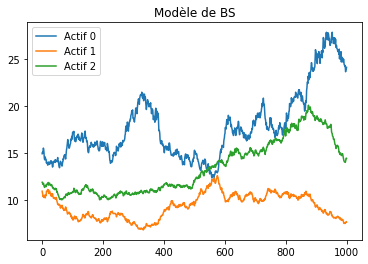

In [ ]:
for k in range(data_cor.shape[1]):
  plt.plot(data_cor[k], label='Actif '+str(k))
  plt.legend()
  plt.title("Modèle de BS")

In [ ]:
cov = np.array([[1]])
mb = MB(cov, N)
liste_S0 = [15]
liste_u = [0.06]
liste_sigma = [ 0.25]
mu_sigma  = [0.2]

actif_non_cor, vol_non_cor = Heston(liste_S0, liste_u, liste_sigma, mu_sigma, N, mb, T, rho=0.5, beta=0.01, alpha=1.0)

In [ ]:
data_non_cor = pd.DataFrame(actif_non_cor, columns=[3])
data_vol_non_cor = pd.DataFrame(vol_non_cor)

In [ ]:
data_non_cor

,3
0,14.837859
1,14.867246
2,14.777930
3,14.694111
4,14.511722
...,...
995,11.813344
996,11.777513
997,11.730322
998,11.784362


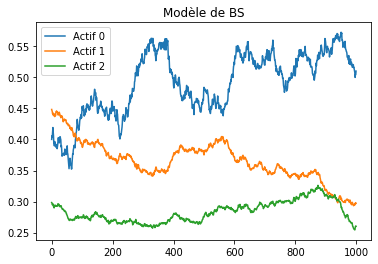

In [ ]:
for k in range(data_vol_cor.shape[1]):
  plt.plot(data_vol_cor[k], label='Actif '+str(k))
  plt.legend()
  plt.title("Modèle de BS")

In [ ]:
data = pd.concat([data_cor, data_non_cor, data_vol_cor, data_vol_non_cor], axis=1)
data.columns = ["actif 1" , "actif 2", "actif 3", "actif 4", "vol 1", "vol 2", "vol 3", "vol 4"]

In [ ]:
data

,actif 1,actif 2,actif 3,actif 4,vol 1,vol 2,vol 3,vol 4
0,14.945441,10.969202,11.918643,14.837859,0.400086,0.448321,0.298404,0.240584
1,15.105646,10.758170,11.871531,14.867246,0.405855,0.446270,0.297756,0.239952
2,14.997398,10.636010,11.709464,14.777930,0.403829,0.444832,0.294867,0.234923
3,15.328393,10.387906,11.690413,14.694111,0.412109,0.441306,0.295231,0.227958
4,15.543903,10.490104,11.806568,14.511722,0.419235,0.442679,0.296430,0.223123
...,...,...,...,...,...,...,...,...
995,24.071698,7.549695,14.029503,11.813344,0.507667,0.294549,0.254345,0.132281
996,23.646013,7.646542,14.152316,11.777513,0.499918,0.297097,0.256821,0.126743
997,23.975334,7.684352,14.382716,11.730322,0.504813,0.297603,0.259768,0.122934
998,23.903261,7.744475,14.480833,11.784362,0.504535,0.298314,0.260702,0.130066


In [ ]:
n_actifs = 4
poids = np.zeros(n_actifs)
somme_prix_actifs = data.values[0,:n_actifs].sum()
somme_prix_actifs

poids = data.values[0, : n_actifs]/somme_prix_actifs
poids  = poids.reshape((-1,1))
Indice = data.values[:,:n_actifs].dot(poids)

In [ ]:
poids

array([[0.28375006],
       [0.20825828],
       [0.22628411],
       [0.28170754]])

In [ ]:
data["Indice"] = Indice
data

,actif 1,actif 2,actif 3,actif 4,vol 1,vol 2,vol 3,vol 4,Indice
0,14.945441,10.969202,11.918643,14.837859,0.400086,0.448321,0.298404,0.240584,13.402133
1,15.105646,10.758170,11.871531,14.867246,0.405855,0.446270,0.297756,0.239952,13.401260
2,14.997398,10.636010,11.709464,14.777930,0.403829,0.444832,0.294867,0.234923,13.283270
3,15.328393,10.387906,11.690413,14.694111,0.412109,0.441306,0.295231,0.227958,13.297597
4,15.543903,10.490104,11.806568,14.511722,0.419235,0.442679,0.296430,0.223123,13.354935
...,...,...,...,...,...,...,...,...,...
995,24.071698,7.549695,14.029503,11.813344,0.507667,0.294549,0.254345,0.132281,14.905194
996,23.646013,7.646542,14.152316,11.777513,0.499918,0.297097,0.256821,0.126743,14.822272
997,23.975334,7.684352,14.382716,11.730322,0.504813,0.297603,0.259768,0.122934,14.962433
998,23.903261,7.744475,14.480833,11.784362,0.504535,0.298314,0.260702,0.130066,14.991929


In [ ]:
data.to_csv('/content/drive/MyDrive/data_Heston.csv', index = False)

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/data_Heston.csv")
data

,actif 1,actif 2,actif 3,actif 4,vol 1,vol 2,vol 3,vol 4,Indice
0,14.945441,10.969202,11.918643,14.837859,0.400086,0.448321,0.298404,0.240584,13.402133
1,15.105646,10.758170,11.871531,14.867246,0.405855,0.446270,0.297756,0.239952,13.401260
2,14.997398,10.636010,11.709464,14.777930,0.403829,0.444832,0.294867,0.234923,13.283270
3,15.328393,10.387906,11.690413,14.694111,0.412109,0.441306,0.295231,0.227958,13.297597
4,15.543903,10.490104,11.806568,14.511722,0.419235,0.442679,0.296430,0.223123,13.354935
...,...,...,...,...,...,...,...,...,...
995,24.071698,7.549695,14.029503,11.813344,0.507667,0.294549,0.254345,0.132281,14.905194
996,23.646013,7.646542,14.152316,11.777513,0.499918,0.297097,0.256821,0.126743,14.822272
997,23.975334,7.684352,14.382716,11.730322,0.504813,0.297603,0.259768,0.122934,14.962433
998,23.903261,7.744475,14.480833,11.784362,0.504535,0.298314,0.260702,0.130066,14.991929


In [ ]:
dataset = data.values
X_train_len= ceil(len(dataset)*0.8) #80% des données de départ
X_train_len

800

In [ ]:
train_data = dataset[:X_train_len,:]
test_data = dataset[X_train_len:,:]

In [ ]:
n_sequence = 5
#on construit un tableau de n_sequence colonnes et de len(train_data)-n_sequence lignes
#les séquences sont de taille n_sequence

X_train= []
y_train= []

for i in range(n_sequence, len(train_data)):
    X_train.append(train_data[(i-n_sequence):i,:-1])
    y_train.append(train_data[i,-1]) #on récupère l'indice

X_train

[array([[14.94544059, 10.96920236, 11.91864333, 14.83785893,  0.40008613,
          0.44832103,  0.29840404,  0.24058422],
        [15.10564591, 10.75816956, 11.87153089, 14.86724613,  0.40585472,
          0.44627027,  0.29775606,  0.23995202],
        [14.99739812, 10.6360097 , 11.70946352, 14.77793035,  0.40382905,
          0.44483223,  0.29486684,  0.23492275],
        [15.32839272, 10.38790588, 11.69041285, 14.69411149,  0.41210865,
          0.44130638,  0.29523105,  0.22795792],
        [15.54390292, 10.49010435, 11.80656805, 14.51172241,  0.41923495,
          0.44267942,  0.29642978,  0.22312277]]),
 array([[15.10564591, 10.75816956, 11.87153089, 14.86724613,  0.40585472,
          0.44627027,  0.29775606,  0.23995202],
        [14.99739812, 10.6360097 , 11.70946352, 14.77793035,  0.40382905,
          0.44483223,  0.29486684,  0.23492275],
        [15.32839272, 10.38790588, 11.69041285, 14.69411149,  0.41210865,
          0.44130638,  0.29523105,  0.22795792],
        [15.54

In [ ]:
y_train

[13.261496905554068,
 13.15357632384335,
 13.00438434884044,
 12.92123515629832,
 12.887318921798048,
 12.924275447839634,
 12.95814048423212,
 12.96313644840913,
 12.889030775568427,
 12.962877658142949,
 12.995600085254129,
 13.047252959769184,
 13.01597425514291,
 12.945237696303291,
 12.898036749144026,
 12.93580456415093,
 12.858189748668403,
 12.914513497351948,
 12.91404857092834,
 12.965639203136732,
 12.94395994896461,
 12.902026514822053,
 12.907664971485762,
 12.87429868704377,
 12.873245475585948,
 12.845944231066902,
 12.861350697526818,
 12.79237303891362,
 12.69703033411454,
 12.663690657828036,
 12.599286477047531,
 12.631565471660023,
 12.74456260859329,
 12.691577352144368,
 12.735618451569746,
 12.79125815120004,
 12.754414945569408,
 12.69455953065074,
 12.81877395307495,
 12.718956017326429,
 12.776269031643276,
 12.817933526749773,
 12.790604635540824,
 12.654465693651224,
 12.677796876103487,
 12.64383137026344,
 12.630636865216571,
 12.475271646338822,
 12.45044

In [ ]:
X_train, y_train=np.array(X_train), np.array(y_train)
X_train.shape

(795, 5, 8)

In [ ]:
y_train.shape

(795,)

#Modélisation

In [ ]:
import math
import torch
import torch.nn as nn
from tqdm import tqdm


class GRU_IB(nn.Module):
    def __init__(self, input_dim, z_dim,time_dim, beta=1, #NN and IB parmeters
                 fixed_r = False,mu_r=0.,logvar_r=0., encoding_loss = 'ib',# Encoding parameter
                 sampling_size = 12,fixed_decoder_scale = True,decoder_scale = 1 # Decoding parameter
                ):
        super(GRU_IB, self).__init__()
        self.z_dim = z_dim
        self.hidden_dim = z_dim*2
        self.time_dim = time_dim
        self.beta = beta
        self.sampling_size = sampling_size
        self.encoding_loss_type = encoding_loss
        if not (encoding_loss=='ib' or encoding_loss=='seq' or encoding_loss=='seq-ent'): # Possible values are 'ib' 'seq' 'parallel'
            print("Unknwon encoding loss type among \'ib\'|\'seq\'|\'seq-ent\'.\nSet to \'ib\'")
            self.encoding_loss_type = 'ib'
        if encoding_loss == 'seq':
            self.beta /= time_dim #The scale of beta is different regarding the time size when we use the sequential loss   
        
        self.rnn = nn.GRUCell(input_dim, self.hidden_dim)
        
        # The linear layer that maps from hidden state space to tag space
        self.decoder = nn.Linear(z_dim, 1) # regression problem
        self.register_parameter(name='decoder_scale',param = nn.Parameter(decoder_scale*torch.ones(size=(1,))))
        if fixed_decoder_scale:
            self.decoder_scale.requires_grad = False
        self.loss_f = nn.MSELoss()
        
        self.loss_histo = []
        self.std_histo = []
        
        # Pivot distribution N(mu,sigma)
        self.register_parameter(name='mu_r',param = nn.Parameter(torch.tensor(mu_r)))
        self.register_parameter(name='logvar_r',param = nn.Parameter(torch.tensor(logvar_r)))
        if fixed_r:
            self.mu_r.requires_grad = False
            self.logvar_r.requires_grad = False
            
        # Cudaize the model
        self.device='cpu'
    
    def cuda(self):
        self.device='cuda'
        return super().cuda()
        
    def rnn_forward(self,x,return_full=False):
        """
        x has dimension like (sample_size,time_size,feature_size)
        """
        H = []
        h = torch.zeros((x.shape[0],self.hidden_dim),device=self.device)
        for t in range(self.time_dim):
            h = self.rnn(x[:,t,:],h)
            if return_full:
                H.append(h)
        res = h
        if return_full:
            res = torch.stack(H,dim=1)
        return res
        
    def encode(self,x,return_full=False):
        h = self.rnn_forward(x,return_full)
        mu,std = h[...,:self.z_dim],h[...,self.z_dim:]
#         expstd = torch.exp(std)
        std = nn.functional.softplus(std,beta=20)
        return mu,std

    def sampling(self,mu,std):
        norm = torch.distributions.Normal(loc=torch.zeros_like(mu),
                                          scale = torch.ones_like(std))
        sampled_std = norm.sample((self.sampling_size,))
        sampled_z = sampled_std * (std.unsqueeze(0)) + mu.unsqueeze(0)
        
        return sampled_z
    
    def decode(self,z):
        return self.decoder(z)
        
    def forward(self, x,return_full = False):
        mu,std = self.encode(x,return_full)
        mu_last = mu
        if return_full:
            mu_last = mu[:,-1,:]
        y_hat = self.decoder(mu_last).squeeze(dim=-1)
        return y_hat,mu,std
    
    def predict(self,x):
        """
        Return a sampled prediction.
        y_hat has the dimension of (sampling_size,x_batch_size)
        """
        mu,std = self.encode(x)
        z = self.sampling(mu,std)
        y_hat = self.decoder(z).squeeze(dim=-1)
        return y_hat     
    
    def compute_kl(self,mu1,logvar1,mu2,logvar2):
        dim = mu1.shape[-1]  
        
        L = logvar2 - logvar1
        D = torch.pow((mu1 - mu2),2) * torch.exp(-logvar2)
        T = (logvar1 - logvar2).exp()
        
        kl = 0.5*(-dim + torch.sum(L+D+T,dim=-1))
        
        return kl
    
    def encoding_loss(self,mu,std):
        """
        Compute KL(p(Z|X) || N(0,1))
        mu,std : encoded parameters. Dependeing on the dimension, it could be a sequence loss, parallel loss etc
        mu_r,logvar_r : comparison gaussian distribution
        """
        
        mu_r = self.mu_r
        logvar_r = self.logvar_r
        logvar = 2*torch.log(std)
        
        kl = self.compute_kl(mu,logvar,mu_r,logvar_r)
        
        return kl.mean(dim=0)
    
    def compute_entropy_gaus(self,logvar):
        """
        Suppose the a multivariate gaussian distribution with diagonal cov matrix (given as a vector)
        """
        
        dim = logvar.shape[-1]
        
        det_sigma = logvar.sum(dim=-1,keepdims=True)
        c = dim/2 * (1 + math.log(2*math.pi))
        
        return 0.5*det_sigma + c 
    
    def encoding_loss_seq(self,Mu,Std,ent=False):
        """
        Attention about using entropy encoding loss function : 
        actuaylly for diferential entropy, the value can be negative !
        For applications, it might be preferable to consider relative entropy (KL)
        """
        
        # Preprocessing
        mu_r = self.mu_r
        logvar_r = self.logvar_r
        mu = Mu
        logvar = 2*torch.log(Std)
    
        # shift t+1 
        mu_shift = mu.roll(-1,dims=1)
        logvar_shift = logvar.roll(-1,dims=1)

        if mu.ndim<3:
            print("Sequence Encoding warning : parameters seems not having time dimension")
        
        kl_t1 = 0
        
        if ent:
            # Use exact mutual information for encoding loss instead kl div. approximation
            ht = self.compute_entropy_gaus(logvar[:,-1,:])
            ht_1 = self.compute_entropy_gaus(logvar_shift[:,-1,:])
            kl_t1 = ht - ht_1
        else:
            kl_t1 = self.compute_kl(mu_shift[:,:-1,:],logvar_shift[:,:-1,:],mu[:,:-1,:],logvar[:,:-1,:])
            
        kl_t0 = self.compute_kl(mu[:,0,:],logvar[:,0,:],self.mu_r,self.logvar_r)

        kl_time = torch.cat([kl_t0.unsqueeze(dim=1),kl_t1],dim=1)
        
        return kl_time.sum(dim=1).mean(dim=0) # Summing the KL in time and mean on batch
    
    def decoding_loss(self,y_hat,y,mu,std):
        """
        Closed form formula for the decoding loss. E[log(q(Y|Z))]
        Sampling with reparametrization trick is not necessry.
        y_hat = w.E[Z] + b = w.mu + b
        """
        
        w = self.decoder.weight
        b = self.decoder.bias
        
#         mse = self.loss_f(y_hat,y)
        mse = torch.pow((y - y_hat),2)
        sigma_l = (w**2 * std**2).sum(dim=1).mean(dim=0)
        
        sigma_decode = self.decoder_scale
        
        l= (mse+sigma_l) / (sigma_decode**2)
        
        sig_loss = torch.log(self.decoder_scale) # The loss for the decoding sigma
        
        return l.mean(dim=0) + sig_loss
    
    def decoding_loss_sampling(self,y_hat,y):
        y = y.repeat([self.sampling_size,1])
        return self.loss_f(y_hat,y) / (self.decoder_scale**2) + torch.log(self.decoder_scale)
    
    def evaluate(self,x,y,return_mse = False):
        """
        Computing the losses : IB loss, KL loss, Predict part Loss.
        """
        
        return_full = False
        ent = False
        enc_loss = self.encoding_loss
        if self.encoding_loss_type[:3] == 'seq':
            return_full = True
            enc_loss = self.encoding_loss_seq
            if self.encoding_loss_type[4:] == 'ent':
                ent = True
        
        y_hat,mu,std = self(x,return_full)
        m = self.decoding_loss(y_hat,y,mu,std)
        k = enc_loss(mu,std)
        l = m+self.beta * k
        
        if return_mse:
            m = self.loss_f(y_hat,y)
        
        return l,m,k
        
    
    def fit(self,train_loader,
            lr=1e-3,epoch=1,
            n_eval_samples = -1):
        
        n_total_samples = len(train_loader)
        
        # Set evaluation data
        if n_eval_samples == -1:
            x_eval = train_loader.dataset.X
            y_eval = train_loader.dataset.y
        elif n_eval_samples>=0 and n_eval_samples<=n_total_samples:
            indices = torch.randperm(n_total_samples)[:n_eval_samples]
            x_eval = train_loader.dataset.X[indices]
            y_eval = train_loader.dataset.y[indices]
        
        # Set optimizer
        optim = torch.optim.Adam(self.parameters(),lr=1e-3)

        pbar = tqdm(range(epoch))
        for e in pbar:
            for x,y in train_loader:
                l,_,_ = self.evaluate(x,y)
                
                optim.zero_grad()
                l.backward()
                optim.step()
                
                    # Measure performance on dataset
            with torch.no_grad():
                
                l,m,k = self.evaluate(x_eval,y_eval,return_mse=True)
                l,m,k = l.item(),m.item(),k.item()
                deco_sc = self.decoder_scale.item()
                pbar.set_postfix({'Loss':l,'kl loss':k,'MSE': m,'decode_sigma':deco_sc,'beta':self.beta})
                self.loss_histo.append(l)
                _,_,std_eval = self(x_eval)
                self.std_histo.append(std_eval)

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset

class DS(Dataset):
    def __init__(self,X,y):

        if not isinstance(X,torch.Tensor):
            X = torch.tensor(X)
        self.X = X.to(dtype=torch.float)

        if not isinstance(y,torch.Tensor):
            y = torch.tensor(y)

        y_type = torch.float
        self.y = y.to(dtype=y_type)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        xi = self.X[idx,:,:]
        yi = self.y[idx]
        return xi,yi


def get_dataloader(X,y,batch_size=1,shuffle=False):
    ds = DS(X,y)
    return DataLoader(ds,batch_size=batch_size,shuffle=shuffle)

In [ ]:
load_train = get_dataloader(X_train, y_train, batch_size=10)

In [ ]:
input_dim = X_train.shape[2]
z_dim = 10
time_dim =  X_train.shape[1]

model_ib = GRU_IB(input_dim, z_dim, time_dim, beta=0.0001)
model_ib_fit = model_ib.fit(load_train, epoch=300, lr=1e-4)

100%|██████████| 300/300 [01:15<00:00,  3.98it/s, Loss=0.0599, kl loss=95.3, MSE=0.0467, decode_sigma=1, beta=0.0001]


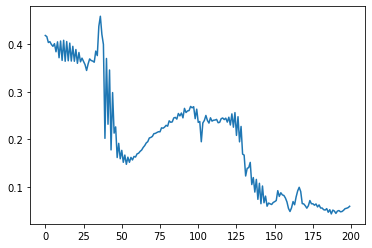

In [ ]:
loss=model_ib.loss_histo
plt.plot(loss[100:])

In [ ]:

#on construit un tableau de n_sequence colonnes et de len(train_data)-n_sequence lignes
#les séquences sont de taille n_sequence

X_test= []
y_true= []

for i in range(n_sequence, len(test_data)):
    X_test.append(test_data[(i-n_sequence):i,:-1])
    y_true.append(test_data[i,-1]) #on récupère l'indice

X_test = np.array(X_test)
y_true = np.array(y_true)

In [ ]:
X_test.shape

(195, 5, 8)

In [ ]:
X_test_load = torch.tensor(X_test).to(dtype=torch.float)


In [ ]:
y_true

array([15.16906473, 15.23725416, 15.30761922, 15.31581178, 15.36138027,
       15.30909451, 15.33823861, 15.51269464, 15.59218785, 15.5401711 ,
       15.58991038, 15.69531535, 15.77905096, 15.90408923, 15.89543447,
       15.67638925, 15.72268208, 15.73360624, 15.87380866, 15.9284869 ,
       15.92640581, 15.91038661, 15.98982195, 16.05158966, 15.96558951,
       15.92352384, 15.8671074 , 16.10849489, 15.97305864, 16.00075376,
       16.00513068, 15.86881329, 15.86163459, 15.80274379, 15.70458722,
       15.80475784, 16.02935053, 16.23124376, 16.20242889, 16.17469813,
       16.03647163, 16.04476056, 16.06371316, 15.9653879 , 16.0561322 ,
       15.85143173, 15.93568559, 15.96626638, 16.05175008, 16.06382086,
       16.00571526, 15.94631386, 15.88033273, 15.80103084, 15.73833542,
       15.88496499, 15.61504652, 15.61454489, 15.63467559, 15.62097062,
       15.86471728, 15.93857367, 16.04398014, 16.26588247, 16.40508084,
       16.53033065, 16.5593905 , 16.5143866 , 16.82360155, 16.82

In [ ]:
preds, _, _ = model_ib(X_test_load)
preds

tensor([15.1934, 15.1355, 15.1172, 15.1945, 15.1582, 15.2113, 15.1722, 15.1649,
        15.2366, 15.2280, 15.2460, 15.2376, 15.2599, 15.2564, 15.2834, 15.2651,
        15.2602, 15.2316, 15.2606, 15.2838, 15.2957, 15.2997, 15.3130, 15.3048,
        15.3215, 15.3171, 15.2893, 15.2848, 15.3111, 15.3055, 15.3003, 15.3100,
        15.2953, 15.2857, 15.2932, 15.2727, 15.2751, 15.2846, 15.3075, 15.3062,
        15.3052, 15.2920, 15.2974, 15.2817, 15.2601, 15.2707, 15.2283, 15.2309,
        15.2449, 15.2732, 15.2796, 15.2783, 15.2705, 15.2750, 15.2352, 15.2663,
        15.2382, 15.2407, 15.1706, 15.2039, 15.1929, 15.2022, 15.1799, 15.1983,
        15.2374, 15.2133, 15.2656, 15.2642, 15.2452, 15.2279, 15.2094, 15.2277,
        15.2609, 15.2426, 15.2532, 15.2337, 15.2441, 15.2331, 15.2318, 15.2599,
        15.2499, 15.2645, 15.2569, 15.2710, 15.2679, 15.3107, 15.3048, 15.2916,
        15.3103, 15.3011, 15.3121, 15.3190, 15.3278, 15.3155, 15.3214, 15.3166,
        15.3244, 15.3325, 15.3260, 15.33

In [ ]:
preds = preds.detach().numpy()
preds.shape

(195,)

In [ ]:
rmse=np.sqrt(np.mean(preds-y_true)**2)
rmse

1.0661565409708342

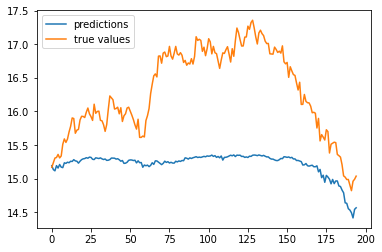

In [ ]:
plt.plot(preds, label ="predictions")
plt.plot(y_true, label="true values")
plt.legend()


#LSTM

In [ ]:
#modèle LSTM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN



In [ ]:
#scaler=MinMaxScaler(feature_range=(-1,1))
#scaled_data=scaler.fit_transform(dataset)

In [ ]:
train_data = dataset[:X_train_len,:]
test_data = dataset[X_train_len:,:]

In [ ]:

#on construit un tableau de n_sequence colonnes et de len(train_data)-n_sequence lignes
#les séquences sont de taille n_sequence

X_train= []
y_train= []

for i in range(n_sequence, len(train_data)):
    X_train.append(train_data[(i-n_sequence):i,:-1])
    y_train.append(train_data[i,-1]) #on récupère l'indice


In [ ]:
#convertir en tableaux numpy
X_train, y_train=np.array(X_train), np.array(y_train)
X_train.shape

(795, 5, 8)

In [ ]:
X_test= []
y_true= []

for i in range(n_sequence, len(test_data)):
    X_test.append(test_data[(i-n_sequence):i,:-1])
    y_true.append(test_data[i,-1]) #on récupère l'indice

X_test = np.array(X_test)
y_true = np.array(y_true).reshape((-1,1))

In [ ]:
model=Sequential()
model.add(LSTM(200,return_sequences=False, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
#Compilation
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mean_squared_error')

In [ ]:
#train the model
history = model.fit(x=X_train, y=y_train, batch_size=7, validation_data = (X_test, y_true), epochs=10)


Epoch 1/10
114/114 [==============================] - 4s 15ms/step - loss: 5.5395 - val_loss: 8.1520
Epoch 2/10
114/114 [==============================] - 1s 11ms/step - loss: 0.3744 - val_loss: 1.6656
Epoch 3/10
114/114 [==============================] - 1s 11ms/step - loss: 0.0526 - val_loss: 0.4806
Epoch 4/10
114/114 [==============================] - 1s 12ms/step - loss: 0.0242 - val_loss: 0.3503
Epoch 5/10
114/114 [==============================] - 1s 10ms/step - loss: 0.0262 - val_loss: 0.3313
Epoch 6/10
114/114 [==============================] - 1s 12ms/step - loss: 0.0237 - val_loss: 0.3410
Epoch 7/10
114/114 [==============================] - 1s 12ms/step - loss: 0.0159 - val_loss: 0.3192
Epoch 8/10
114/114 [==============================] - 1s 11ms/step - loss: 0.0162 - val_loss: 0.3678
Epoch 9/10
114/114 [==============================] - 1s 10ms/step - loss: 0.0142 - val_loss: 0.3903
Epoch 10/10
114/114 [==============================] - 1s 11ms/step - loss: 0.0133 - val_lo

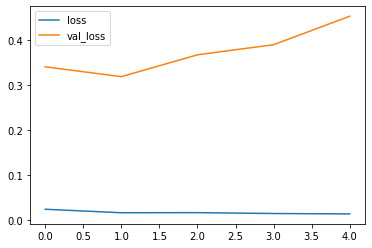

In [ ]:
loss = history.history["loss"][5:]
val_loss = history.history["val_loss"][5:]

plt.plot(loss, label = "loss")
plt.plot(val_loss, label = "val_loss")
plt.legend()

In [ ]:
predictions=model.predict(X_test)

In [ ]:
rmse=np.sqrt(np.mean(predictions-y_true)**2)
rmse

0.8756495276010049

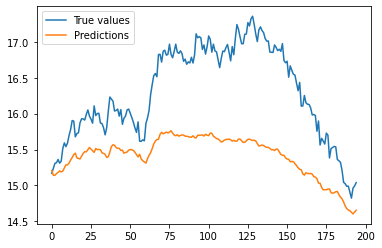

In [ ]:
plt.plot(y_true, label= "True values")
plt.plot(predictions, label= "Predictions")
plt.legend()

#CNN

In [ ]:
# multivariate cnn example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [ ]:
# define model
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(optimizer='adam', loss='mse')
# fit model
history = model_cnn.fit(X_train, y_train, epochs=15, verbose=1, validation_data = (X_test, y_true),  batch_size=10)

Epoch 1/15
80/80 [==============================] - 1s 4ms/step - loss: 6.7803 - val_loss: 0.2316
Epoch 2/15
80/80 [==============================] - 0s 2ms/step - loss: 0.0444 - val_loss: 0.1073
Epoch 3/15
80/80 [==============================] - 0s 3ms/step - loss: 0.0277 - val_loss: 0.0862
Epoch 4/15
80/80 [==============================] - 0s 3ms/step - loss: 0.0243 - val_loss: 0.0743
Epoch 5/15
80/80 [==============================] - 0s 3ms/step - loss: 0.0223 - val_loss: 0.0810
Epoch 6/15
80/80 [==============================] - 0s 3ms/step - loss: 0.0223 - val_loss: 0.0586
Epoch 7/15
80/80 [==============================] - 0s 3ms/step - loss: 0.0220 - val_loss: 0.0909
Epoch 8/15
80/80 [==============================] - 0s 3ms/step - loss: 0.0200 - val_loss: 0.0483
Epoch 9/15
80/80 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0599
Epoch 10/15
80/80 [==============================] - 0s 3ms/step - loss: 0.0199 - val_loss: 0.0448
Epoch 11/15
80/80 [

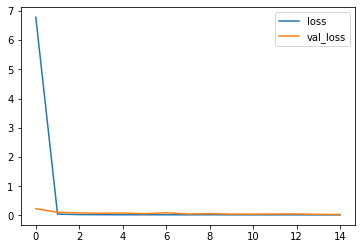

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(loss, label = "loss")
plt.plot(val_loss, label = "val_loss")
plt.legend()

In [ ]:
pred_cnn = model_cnn.predict(X_test)

In [ ]:
rmse_cnn = np.sqrt(np.mean(pred_cnn-y_true)**2)
rmse_cnn

0.07660691473798764

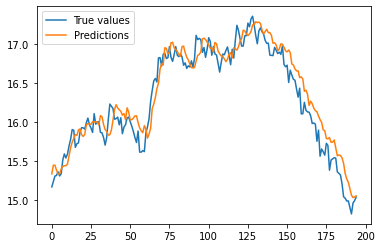

In [ ]:
plt.plot(y_true, label= "True values")
plt.plot(pred_cnn, label= "Predictions")
plt.legend()